## Load Data Directory

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("moanlobago/crop-pestdatasets")

# print("Path to dataset files:", path)

## Dependencies

In [2]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

Essential building blocks for neural networks, optimization, and data handling

In [3]:
# Vision-specific imports
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder

 Pre-trained models, image transformations, and dataset utilities designed for computer vision tasks

In [4]:
# Image processing
from PIL import Image
import cv2

Tools for loading, manipulating, and preprocessing your maize leaf images

In [5]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

For exploring your dataset, visualizing results, and handling any metadata you might create

In [6]:
# System and file handling
import os
import glob
from pathlib import Path
import random
import shutil

# Model evaluation and metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Progress tracking and utilities
from tqdm import tqdm
import time
import copy
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [7]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [8]:
# Set your dataset path
dataset_path = Path('/kaggle/input/crop-pestdatasets/Combined_pestDataset')

In [9]:
train = pd.read_csv(dataset_path / 'Train.csv')
test = pd.read_csv(dataset_path / 'Test.csv')

In [10]:
train.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [11]:
train['Label'].value_counts()

Label
0    810
1    809
Name: count, dtype: int64

## Data Preprocessing

#### Data Transformation

In [12]:
# Transformations for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((512, 512)),       # Random crop to 512x512
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.ToTensor(),                   # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Transformations for validation data
val_transforms = transforms.Compose([
    transforms.Resize((512, 512)),                  # Resize to 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Data Preparation

In [13]:
source_dir = dataset_path / 'Images'
output_dir = '/kaggle/working/dataset_path'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create train class folders
for label in train['Label'].unique():
    os.makedirs(os.path.join(train_dir, str(label)), exist_ok=True)

# Create test folder (no class folders)
os.makedirs(test_dir, exist_ok=True)

# Move train images
for _, row in train.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    dst = os.path.join(train_dir, str(row['Label']), row['Image_id'])
    if os.path.exists(src):
        shutil.copy2(src, dst)

# Move test images
for _, row in test.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    dst = os.path.join(test_dir, row['Image_id'])
    if os.path.exists(src):
        shutil.copy2(src, dst)

#### Log Missing Images

In [14]:
missing_files = []
for _, row in train.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    if not os.path.exists(src):
        missing_files.append(row['Image_id'])

if missing_files:
    print(f"Missing {len(missing_files)} training images")


#### Load the training dataset

In [15]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)

#### Handling test set

In [16]:
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(image_path)

In [17]:
test_image_paths = list(Path(test_dir).glob("*.jpg"))  # adjust ext if needed
test_dataset = TestDataset(test_image_paths, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Create DataLoaders

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

#### Confirm class mapping

In [19]:
print(train_dataset.class_to_idx)

{'0': 0, '1': 1}


In [20]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.4


## Model training

In [21]:
num_classes = len(train_dataset.classes)

num_classes

2

#### Custom CNN Model

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256x256

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 64 * 64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [23]:
model_cnn = SimpleCNN(num_classes).to(device)

#### Pretrained ResNet Model

In [24]:
resnet = models.resnet18(pretrained=True)

# Freeze feature extractor layers (optional)
for param in resnet.parameters():
    param.requires_grad = False

# Replace final layer
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

model_resnet = resnet.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.8MB/s]


#### Training Loop

In [25]:
def train_model(model, train_loader, num_epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        print(f"Epoch {epoch+1}: Loss = {running_loss/total:.4f}, Accuracy = {100*correct/total:.2f}%")


#### Train Both Models

#### Custom CNN

In [26]:
train_model(model_cnn, train_loader, num_epochs=5)

Epoch 1/5: 100%|██████████| 51/51 [00:20<00:00,  2.48it/s, acc=55.9, loss=0.769]


Epoch 1: Loss = 1.4644, Accuracy = 55.90%


Epoch 2/5: 100%|██████████| 51/51 [00:20<00:00,  2.43it/s, acc=60.1, loss=0.715]


Epoch 2: Loss = 0.6815, Accuracy = 60.10%


Epoch 3/5: 100%|██████████| 51/51 [00:20<00:00,  2.52it/s, acc=65.2, loss=0.668]


Epoch 3: Loss = 0.6523, Accuracy = 65.23%


Epoch 4/5: 100%|██████████| 51/51 [00:18<00:00,  2.69it/s, acc=73.9, loss=0.432]


Epoch 4: Loss = 0.5419, Accuracy = 73.87%


Epoch 5/5: 100%|██████████| 51/51 [00:20<00:00,  2.53it/s, acc=81.6, loss=0.411]

Epoch 5: Loss = 0.4239, Accuracy = 81.59%


#### ResNet

In [27]:
train_model(model_resnet, train_loader, num_epochs=5)

Epoch 1/5: 100%|██████████| 51/51 [00:19<00:00,  2.58it/s, acc=72.1, loss=0.458]


Epoch 1: Loss = 0.5701, Accuracy = 72.14%


Epoch 2/5: 100%|██████████| 51/51 [00:17<00:00,  2.88it/s, acc=88.5, loss=0.405]


Epoch 2: Loss = 0.3629, Accuracy = 88.51%


Epoch 3/5: 100%|██████████| 51/51 [00:18<00:00,  2.81it/s, acc=91.2, loss=0.317]


Epoch 3: Loss = 0.2861, Accuracy = 91.23%


Epoch 4/5: 100%|██████████| 51/51 [00:18<00:00,  2.81it/s, acc=92.1, loss=0.314]


Epoch 4: Loss = 0.2625, Accuracy = 92.09%


Epoch 5/5: 100%|██████████| 51/51 [00:17<00:00,  2.84it/s, acc=92.1, loss=0.117]

Epoch 5: Loss = 0.2340, Accuracy = 92.09%


## Evaluation

#### Evaluation function

In [28]:
def evaluate_and_plot(model, test_loader, class_names, num_images=16):
    model.eval()
    images_shown = 0
    images_to_plot = []
    preds_to_plot = []

    with torch.no_grad():
        for images, image_names in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                images_to_plot.append(images[i].cpu())
                preds_to_plot.append(class_names[preds[i].item()])
                images_shown += 1

            if images_shown >= num_images:
                break

    # Denormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images_to_plot = [(img * std[:, None, None] + mean[:, None, None]).clamp(0, 1) for img in images_to_plot]

    # Plot
    grid = torchvision.utils.make_grid(images_to_plot, nrow=4)
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Predicted Labels:\n" + ", ".join(preds_to_plot))
    plt.axis('off')
    plt.show()

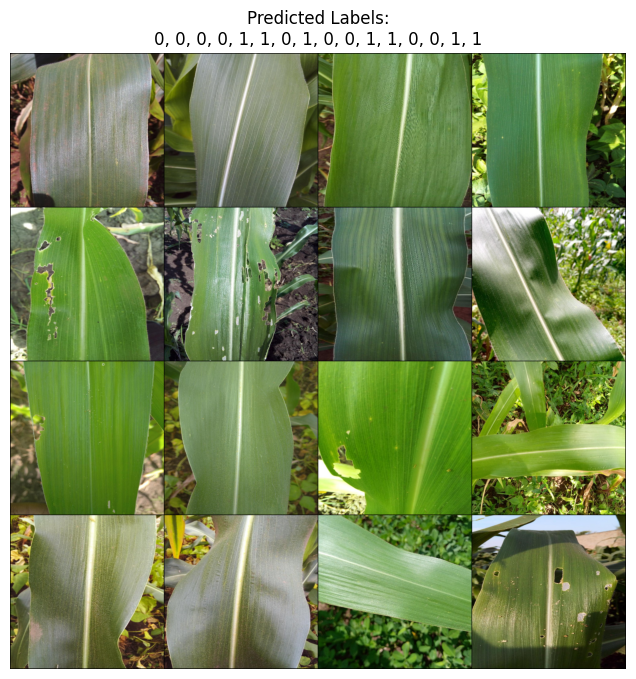

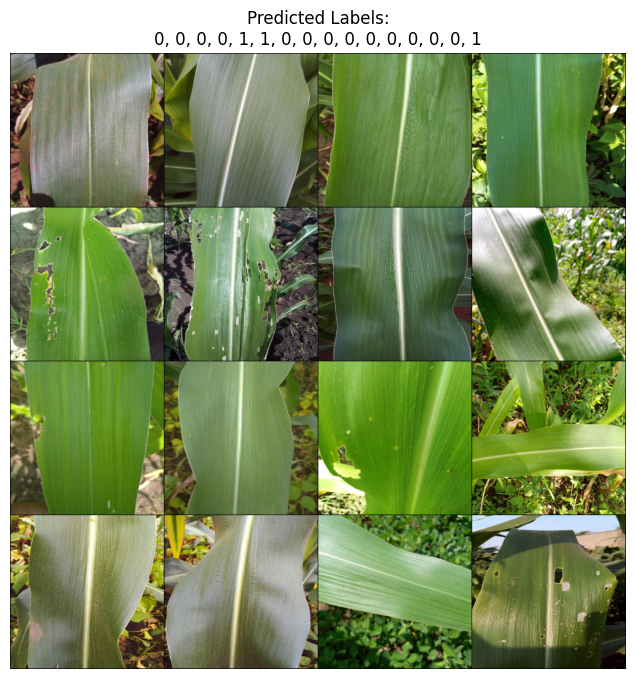

In [29]:
evaluate_and_plot(model_cnn, test_loader, train_dataset.classes)
evaluate_and_plot(model_resnet, test_loader, train_dataset.classes)